# Summary

# Trying out some stuff

## A simple univariate case

From ChatGPT:

**Background**: A local hospital is trying to understand factors that might influence the recovery speed (measured as the number of days spent in the hospital) after undergoing a specific surgery. The surgical procedure is common and is performed on both patients who are smokers and those who are non-smokers. Moreover, patients have the option of undergoing either a traditional surgical method or a newer, minimally invasive method.

**Research Question**: Does smoking status and the type of surgical method influence the recovery time of patients?

**Binary Variables**:

- Smoking Status:

    - 0: Non-Smoker
    - 1: Smoker

- Surgical Method:

    - 0: Traditional Surgery    
    - 1: Minimally Invasive Surgery (new surgery)

**Outcome Variable**: Recovery time: A continuous variable representing the number of days a patient spends in the hospital post-surgery.

**Data Collection**:
The hospital collects data over a year from patients who underwent the procedure, noting down their smoking status, the type of surgical method, and their recovery time.

**Regression Story**:
- Smokers who undergo traditional surgery have a significantly longer recovery time compared to non-smokers who undergo the same traditional method. This could be due to the overall decreased lung efficiency and increased risk of post-surgical complications in smokers.

- However, when opting for the minimally invasive method, the difference in recovery time between smokers and non-smokers narrows down. The minimally invasive procedure, being less taxing on the body, might be reducing the impact of smoking on recovery.

- On its own, the minimally invasive surgery results in faster recovery times compared to the traditional method for both smokers and non-smokers. Yet, the advantage of the minimally invasive method seems even more pronounced for smokers, making it a favorable option for this group.

**Conclusion**:
The hospital might consider recommending the minimally invasive surgical method, especially for smokers, to ensure faster recovery times. Additionally, pre-surgical counseling for smokers about the risks and benefits associated with each method could be beneficial.

In [1]:
library(data.table)
library(PSweight)
library(ggplot2)

In [2]:
N <- 200      ## nb of patients in each group
p_s <- 0.75   ## pct smokers in treatment group

In [3]:
## 75% percent smoker in the test group, 25% in the control group:
ex1 <- data.table(test=rep(c(TRUE, FALSE), each=N), 
                  smoker=c(as.logical(rbinom(N, 1, p_s)), as.logical(rbinom(N, 1, 1 - p_s))))
print(ex1)

      test smoker
  1:  TRUE  FALSE
  2:  TRUE   TRUE
  3:  TRUE  FALSE
  4:  TRUE   TRUE
  5:  TRUE   TRUE
 ---             
396: FALSE  FALSE
397: FALSE  FALSE
398: FALSE  FALSE
399: FALSE  FALSE
400: FALSE   TRUE


In [4]:
# smokers have mean 60 days recovery, non-smokers 30 days
ex1[smoker==TRUE, recovery := rnorm(sum(ex1$smoker), 60, 6)]
ex1[smoker==FALSE, recovery := rnorm(sum(!ex1$smoker), 30, 3)]
print(ex1, topn=10)

      test smoker recovery
  1:  TRUE  FALSE 33.28927
  2:  TRUE   TRUE 62.00643
  3:  TRUE  FALSE 36.13550
  4:  TRUE   TRUE 63.31164
  5:  TRUE   TRUE 61.32759
  6:  TRUE   TRUE 71.70983
  7:  TRUE   TRUE 63.70314
  8:  TRUE   TRUE 65.27186
  9:  TRUE   TRUE 53.15921
 10:  TRUE   TRUE 64.25257
 ---                      
391: FALSE  FALSE 29.32898
392: FALSE  FALSE 33.08611
393: FALSE  FALSE 32.15553
394: FALSE  FALSE 33.60305
395: FALSE  FALSE 30.04794
396: FALSE  FALSE 29.48005
397: FALSE  FALSE 33.81306
398: FALSE  FALSE 36.35417
399: FALSE  FALSE 30.39727
400: FALSE   TRUE 65.11594


In [5]:
logistic_model <- glm("test ~ smoker", family=binomial, data=ex1)
summary(logistic_model)


Call:
glm(formula = "test ~ smoker", family = binomial, data = ex1)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.59347  -0.77235   0.01992   0.81219   1.64633  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.0569     0.1658  -6.374 1.85e-10 ***
smokerTRUE    1.9967     0.2260   8.835  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 554.52  on 399  degrees of freedom
Residual deviance: 466.34  on 398  degrees of freedom
AIC: 470.34

Number of Fisher Scoring iterations: 4


In [6]:
## get the probabilities of belonging to the treatment group, the propensity:
ex1[, propensity := predict(logistic_model, ex1[, .(smoker)], type="response")]
print(ex1, topn=10)

      test smoker recovery propensity
  1:  TRUE  FALSE 33.28927  0.2578947
  2:  TRUE   TRUE 62.00643  0.7190476
  3:  TRUE  FALSE 36.13550  0.2578947
  4:  TRUE   TRUE 63.31164  0.7190476
  5:  TRUE   TRUE 61.32759  0.7190476
  6:  TRUE   TRUE 71.70983  0.7190476
  7:  TRUE   TRUE 63.70314  0.7190476
  8:  TRUE   TRUE 65.27186  0.7190476
  9:  TRUE   TRUE 53.15921  0.7190476
 10:  TRUE   TRUE 64.25257  0.7190476
 ---                                 
391: FALSE  FALSE 29.32898  0.2578947
392: FALSE  FALSE 33.08611  0.2578947
393: FALSE  FALSE 32.15553  0.2578947
394: FALSE  FALSE 33.60305  0.2578947
395: FALSE  FALSE 30.04794  0.2578947
396: FALSE  FALSE 29.48005  0.2578947
397: FALSE  FALSE 33.81306  0.2578947
398: FALSE  FALSE 36.35417  0.2578947
399: FALSE  FALSE 30.39727  0.2578947
400: FALSE   TRUE 65.11594  0.7190476


In [7]:
## now calculate the weights:
ex1[test==TRUE, weight := 1 / propensity]
ex1[test==FALSE, weight := 1 / (1 - propensity)]
print(ex1, topn=10)

      test smoker recovery propensity   weight
  1:  TRUE  FALSE 33.28927  0.2578947 3.877551
  2:  TRUE   TRUE 62.00643  0.7190476 1.390728
  3:  TRUE  FALSE 36.13550  0.2578947 3.877551
  4:  TRUE   TRUE 63.31164  0.7190476 1.390728
  5:  TRUE   TRUE 61.32759  0.7190476 1.390728
  6:  TRUE   TRUE 71.70983  0.7190476 1.390728
  7:  TRUE   TRUE 63.70314  0.7190476 1.390728
  8:  TRUE   TRUE 65.27186  0.7190476 1.390728
  9:  TRUE   TRUE 53.15921  0.7190476 1.390728
 10:  TRUE   TRUE 64.25257  0.7190476 1.390728
 ---                                          
391: FALSE  FALSE 29.32898  0.2578947 1.347518
392: FALSE  FALSE 33.08611  0.2578947 1.347518
393: FALSE  FALSE 32.15553  0.2578947 1.347518
394: FALSE  FALSE 33.60305  0.2578947 1.347518
395: FALSE  FALSE 30.04794  0.2578947 1.347518
396: FALSE  FALSE 29.48005  0.2578947 1.347518
397: FALSE  FALSE 33.81306  0.2578947 1.347518
398: FALSE  FALSE 36.35417  0.2578947 1.347518
399: FALSE  FALSE 30.39727  0.2578947 1.347518
400: FALSE   

In [8]:
print(sum(ex1[test==TRUE ]$smoker)    / nrow(ex1[test==TRUE]))
print(sum(ex1[test==FALSE]$smoker)    / nrow(ex1[test==FALSE]))
print(sum(ex1[test  & smoker]$weight) / sum(ex1[test==TRUE]$weight))
print(sum(ex1[!test & smoker]$weight) / sum(ex1[test==FALSE]$weight))

[1] 0.755
[1] 0.295
[1] 0.525
[1] 0.525


Without the propensity weights, we see that the difference between test and control group is significant:

In [9]:
summary(aov(recovery ~ test, data=ex1))

             Df Sum Sq Mean Sq F value Pr(>F)    
test          1  16269   16269   76.27 <2e-16 ***
Residuals   398  84893     213                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

But when we use the weights, we see that this difference is not significant, because it is entirely explained by the higher percentage of smokers in the test group, which is "matched" out when we use the weights:

In [10]:
summary(aov(recovery ~ test, data=ex1, weights=ex1$weight))

             Df Sum Sq Mean Sq F value Pr(>F)
test          1    382   382.2    0.73  0.394
Residuals   398 208474   523.8               

### Checking with PSweight

In [11]:
ipw <- PSweight(test ~ smoker, data=ex1, yname="recovery", weight="IPW")
print(summary(ipw))
ipw


Closed-form inference: 

Original group value:  FALSE, TRUE 

Contrast: 
           FALSE TRUE
Contrast 1    -1    1

           Estimate Std.Error     lwr      upr Pr(>|z|)  
Contrast 1  -1.3823    0.5448 -2.4501 -0.31452  0.01117 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Original group value:  FALSE, TRUE 

Point estimate: 
46.8693, 45.487 

In [12]:
summary(ipw)


Closed-form inference: 

Original group value:  FALSE, TRUE 

Contrast: 
           FALSE TRUE
Contrast 1    -1    1

           Estimate Std.Error     lwr      upr Pr(>|z|)  
Contrast 1  -1.3823    0.5448 -2.4501 -0.31452  0.01117 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

## Problems

### Missing propensity variable

### Small divisors

We introduce a new covariate `new_surgery`. In the test group, we assign all smokers to new_surgery and all non-smokers to non-new_surgerys; in the control group, we assign the new_surgerys randomly to the whole population with the same probability as the probability of being smoker in the control group (0.75).

In [13]:
ex2 <- copy(ex1)
ex2[test==TRUE, new_surgery := smoker]
#ex2[test & smoker, new_surgery := rbinom(nrow(ex2[test & smoker]), 1, 0.9)]
#ex2[test & !smoker, new_surgery := rbinom(nrow(ex2[test & !smoker]), 1, 0.1)]
ex2[test==FALSE, new_surgery := rbinom(nrow(ex2[test==FALSE]), 1, p_s)]

In [14]:
## percent smoker new_surgerys:
nrow(ex2[test & smoker & new_surgery])/nrow(ex2[test & smoker])

[1] 1

In [15]:
## percent male new_surgerys:
nrow(ex2[test & !smoker & new_surgery])/nrow(ex2[test & !smoker])

[1] 0

In [16]:
logistic_model <- glm("test ~ smoker + new_surgery", family=binomial, data=ex2)
summary(logistic_model)


Call:
glm(formula = "test ~ smoker + new_surgery", family = binomial, 
    data = ex2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3252  -0.5142   0.1630   0.8402   1.2556  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -0.1821     0.2239  -0.813    0.416    
smokerTRUE        2.8161     0.3113   9.046  < 2e-16 ***
new_surgeryTRUE  -1.7744     0.3454  -5.137 2.79e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 554.52  on 399  degrees of freedom
Residual deviance: 435.50  on 397  degrees of freedom
AIC: 441.5

Number of Fisher Scoring iterations: 4


In [17]:
ex2[, propensity := predict(logistic_model, ex2, type="response")]
ex2[test==TRUE, weight := 1 / propensity]
ex2[test==FALSE, weight := 1 / (1 - propensity)]
print(ex2, topn=10)

      test smoker recovery propensity   weight new_surgery
  1:  TRUE  FALSE 33.28927  0.4546066 2.199704       FALSE
  2:  TRUE   TRUE 62.00643  0.7025882 1.423309        TRUE
  3:  TRUE  FALSE 36.13550  0.4546066 2.199704       FALSE
  4:  TRUE   TRUE 63.31164  0.7025882 1.423309        TRUE
  5:  TRUE   TRUE 61.32759  0.7025882 1.423309        TRUE
  6:  TRUE   TRUE 71.70983  0.7025882 1.423309        TRUE
  7:  TRUE   TRUE 63.70314  0.7025882 1.423309        TRUE
  8:  TRUE   TRUE 65.27186  0.7025882 1.423309        TRUE
  9:  TRUE   TRUE 53.15921  0.7025882 1.423309        TRUE
 10:  TRUE   TRUE 64.25257  0.7025882 1.423309        TRUE
 ---                                                      
391: FALSE  FALSE 29.32898  0.1238521 1.141360        TRUE
392: FALSE  FALSE 33.08611  0.1238521 1.141360        TRUE
393: FALSE  FALSE 32.15553  0.1238521 1.141360        TRUE
394: FALSE  FALSE 33.60305  0.1238521 1.141360        TRUE
395: FALSE  FALSE 30.04794  0.1238521 1.141360        TR

In [18]:
summary(aov(recovery ~ test, data=ex2))

             Df Sum Sq Mean Sq F value Pr(>F)    
test          1  16269   16269   76.27 <2e-16 ***
Residuals   398  84893     213                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [19]:
summary(aov(recovery ~ test, data=ex2, weights=ex2$weight))

             Df Sum Sq Mean Sq F value Pr(>F)
test          1    324   324.5   0.643  0.423
Residuals   398 200983   505.0               

In [20]:
print(sum(ex2[test==TRUE]$smoker)/nrow(ex2[test==TRUE]))
print(sum(ex2[test==FALSE]$smoker)/nrow(ex2[test==FALSE]))
print(sum(ex2[test &  smoker]$weight)/sum(ex2[test==TRUE]$weight))
print(sum(ex2[!test & smoker]$weight)/sum(ex2[test==FALSE]$weight))

[1] 0.755
[1] 0.295
[1] 0.6659938
[1] 0.6734657


In [21]:
print(sum(ex2[test==TRUE]$new_surgery)/nrow(ex2[test==TRUE]))
print(sum(ex2[test==FALSE]$new_surgery)/nrow(ex2[test==FALSE]))
print(sum(ex2[test &  new_surgery]$weight)/sum(ex2[test==TRUE]$weight))
print(sum(ex2[!test & new_surgery]$weight)/sum(ex2[test==FALSE]$weight))

[1] 0.755
[1] 0.785
[1] 0.6659938
[1] 0.5014775


Now let's imagine new_surgery has an effect, if you're a new_surgery, you're 15 recovery lighter:

In [22]:
ex2[new_surgery==TRUE, recovery := recovery + 50]

In [23]:
summary(aov(recovery ~ test, data=ex2))

             Df Sum Sq Mean Sq F value   Pr(>F)    
test          1  12668   12668   13.67 0.000248 ***
Residuals   398 368759     927                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

We find then with these weights that the test group is significantly different from the control group, which we know by design of this simulation is not true:

In [24]:
summary(aov(recovery ~ test, data=ex2, weights=ex2$weight))

             Df Sum Sq Mean Sq F value Pr(>F)  
test          1   9877    9877   4.658 0.0315 *
Residuals   398 843977    2121                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

### Running PSweight

In [25]:
ipw <- PSweight(test ~ smoker + new_surgery, data=ex2, yname="recovery", weight="IPW")
print(ipw)
summary(ipw)

Original group value:  FALSE, TRUE 

Point estimate: 
76.0809, 83.0445 



Closed-form inference: 

Original group value:  FALSE, TRUE 

Contrast: 
           FALSE TRUE
Contrast 1    -1    1

           Estimate Std.Error     lwr    upr Pr(>|z|)  
Contrast 1  6.96366   3.09046 0.90646 13.021  0.02424 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [26]:
ipw_ss <- SumStat(test ~ smoker + new_surgery, data=ex2, weight="IPW")
summary(ipw_ss)

unweighted result
                Mean FALSE Mean TRUE   SMD
smokerTRUE           0.295     0.755 1.035
new_surgeryTRUE      0.785     0.755 0.071

IPW result
                Mean FALSE Mean TRUE   SMD
smokerTRUE           0.673     0.666 0.017
new_surgeryTRUE      0.501     0.666 0.390


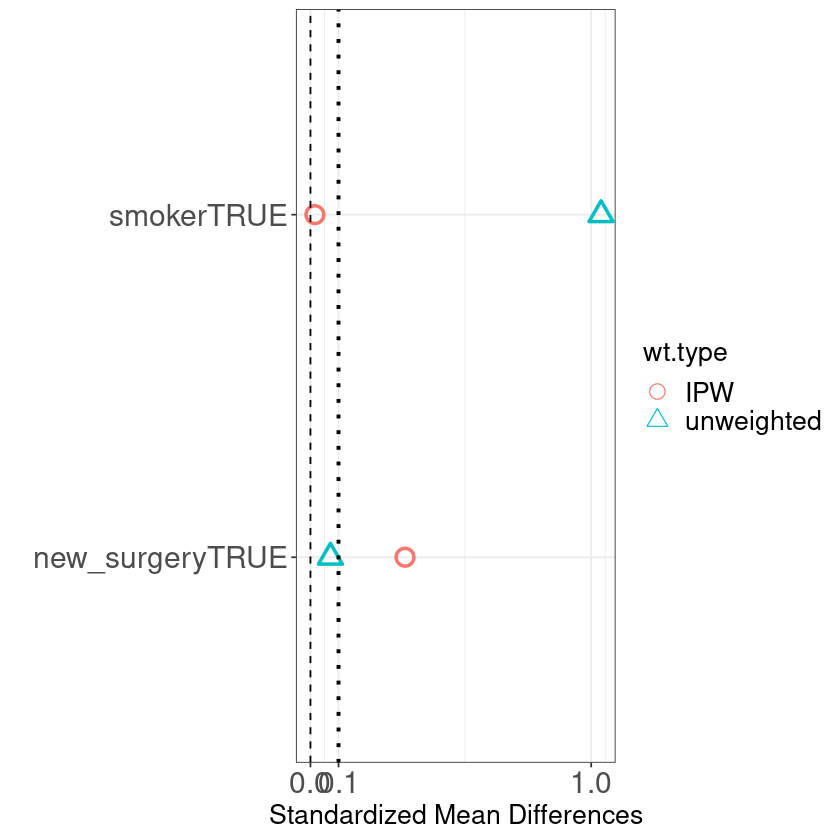

In [27]:
plot(ipw_ss)

In [28]:
aipw <- PSweight(test ~ smoker + new_surgery, data=ex2, yname="recovery", weight="IPW", 
                augmentation = TRUE, out.formula = recovery ~ smoker + new_surgery)
summary(ipw)

Warning message in predict.lm(fitglm, type = "response", dataout):
“prediction from a rank-deficient fit may be misleading”



Closed-form inference: 

Original group value:  FALSE, TRUE 

Contrast: 
           FALSE TRUE
Contrast 1    -1    1

           Estimate Std.Error     lwr    upr Pr(>|z|)  
Contrast 1  6.96366   3.09046 0.90646 13.021  0.02424 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

# AIPW

Let's examine the Augmented Inverse Propensity Weighting. We start by simulating a simple treatment/control group with a couple of covariates.

$$Y_{i} \sim X_{i}\beta + W_{i}\tau + \epsilon$$

To add some realism, we'll have our treatment have a different range of X and fix $\beta$ and $\tau$.

$$X_{treat} \sim Normal(\mu=4, \sigma=1)$$
$$X_{cntl} \sim Normal(\mu=6, \sigma=1)$$
$$\beta = 2$$
$$\tau = 1$$
$$\epsilon \sim Normal(\mu=0.2, \sigma=1)$$

In [29]:
sz <- 250
beta1 <- 2
tau <- 1
mu_epsilon <- 0.1
dt <- data.table(x1=c(rnorm(sz, 4, 1), rnorm(sz, 6, 1)), 
                 W=c(rep(1, sz), rep(0, sz)),
                 epsilon=rnorm(sz*2, mu_epsilon, 1))
dt[, y := x1 * beta1 + W * tau + epsilon]
print(summary(dt[W==1]))
print(summary(dt[W==0]))

       x1              W        epsilon               y         
 Min.   :1.050   Min.   :1   Min.   :-3.14863   Min.   : 1.549  
 1st Qu.:3.223   1st Qu.:1   1st Qu.:-0.58325   1st Qu.: 7.413  
 Median :3.991   Median :1   Median : 0.07615   Median : 9.019  
 Mean   :3.895   Mean   :1   Mean   : 0.10692   Mean   : 8.896  
 3rd Qu.:4.526   3rd Qu.:1   3rd Qu.: 0.71406   3rd Qu.:10.344  
 Max.   :6.965   Max.   :1   Max.   : 3.26845   Max.   :14.830  
       x1              W        epsilon               y         
 Min.   :3.728   Min.   :0   Min.   :-2.69898   Min.   : 6.271  
 1st Qu.:5.469   1st Qu.:0   1st Qu.:-0.60568   1st Qu.:10.727  
 Median :5.966   Median :0   Median : 0.05101   Median :12.165  
 Mean   :6.033   Mean   :0   Mean   : 0.07778   Mean   :12.144  
 3rd Qu.:6.662   3rd Qu.:0   3rd Qu.: 0.75870   3rd Qu.:13.484  
 Max.   :9.676   Max.   :0   Max.   : 3.32238   Max.   :19.146  


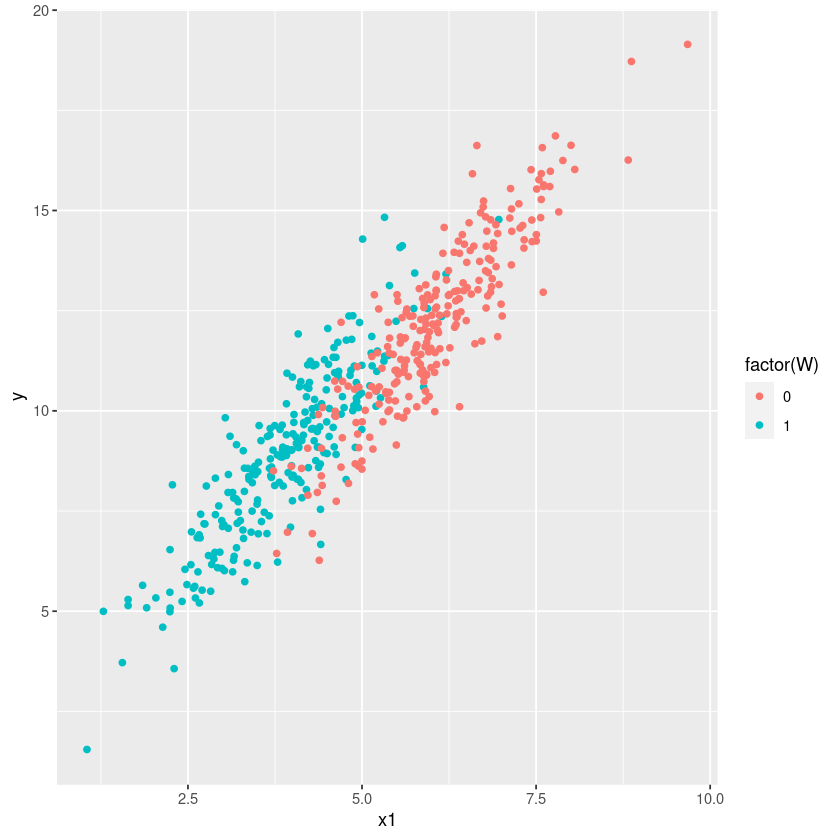

In [30]:
ggplot(dt, aes(x1, y, color=factor(W))) +
    geom_point()

## IPW

First we use a logistic regression to figure out the propensity score *e(i)*

In [31]:
propensity_model <- glm(W ~ x1, data=dt, family=binomial)
summary(propensity_model)


Call:
glm(formula = W ~ x1, family = binomial, data = dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5201  -0.3894   0.0031   0.4030   3.1863  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  12.5832     1.1255   11.18   <2e-16 ***
x1           -2.5347     0.2249  -11.27   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 693.15  on 499  degrees of freedom
Residual deviance: 291.30  on 498  degrees of freedom
AIC: 295.3

Number of Fisher Scoring iterations: 6


In [32]:
dt[, e := predict(propensity_model, data=dt, type="response")]
print(dt)

           x1 W    epsilon         y            e
  1: 5.323266 1  3.1835314 14.830064 0.2870958157
  2: 5.374271 1 -0.3677916 11.380751 0.2613793333
  3: 4.065872 1 -0.8352748  8.296470 0.9070007383
  4: 4.460830 1  1.3554561 11.277116 0.7818470657
  5: 2.457577 1  0.1301001  6.045255 0.9982633418
 ---                                             
496: 6.948340 0 -2.0440498 11.852630 0.0065056255
497: 6.400904 0 -2.6989842 10.102823 0.0255561266
498: 7.825675 0 -0.6868572 14.964493 0.0007080273
499: 3.983302 0  0.6466926  8.613298 0.9232140547
500: 5.599824 0 -1.3608747  9.838774 0.1665170864


And now we can estimate the propensity weighted means and see what $\tau$ we get:

In [33]:
mu1 <- sum(dt$W * dt$y / dt$e) / sum(dt$W / dt$e)
mu0 <- sum((1-dt$W) * dt$y / (1-dt$e)) / sum((1 - dt$W) / (1 - dt$e))
cat(paste("mu1:", mu1, "\n"))
cat(paste("mu0:", mu0, "\n"))
ATE_prop <- mu1 - mu0
print(ATE_prop)

mu1: 11.3937031862549 
mu0: 10.6911328619948 
[1] 0.7025703


So it's fair to say we've done a reasonable job of estimating tau.

## Regression

Now let's look at a second way of approching the problem. Here we estimate directly $\mu_{0}$
and $\mu_{1}$ from the treatment and control groups, conditional on X.

Note the regression is conducted separately on the two groups. It is not:

$$Y \sim X\beta + W\tau + \epsilon$$

but instead:

$$Y_{1} \sim X_{1}\beta_{1} + \epsilon$$
$$Y_{0} \sim X_{0}\beta_{0} + \epsilon$$

"We emphasize that, throughout our analysis, we defined the target estimand τ = E [∆i] before making any modeling assumptions. Linear modeling was only used as a tool to estimate τ , but did not inform the scientific question we tried to answer. In particular, we did not try to estimate τ by direct regression modeling $Y_{i} \sim X_{i}\beta + W_{i}\tau + \epsilon_{i}$, while claiming that the coefficient on τ is a causal effect. This approach has the vice of tying our scientific question to our regression modeling strategy: τ appears to just have become a coefficient in our linear model, not a fact of nature that’s conceptually prior to modeling decisions." (https://web.stanford.edu/~swager/stats361.pdf, page 8).

In [34]:
model_mu1 <- lm(y ~ x1, data=dt[W==1])
summary(model_mu1)


Call:
lm(formula = y ~ x1, data = dt[W == 1])

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2485 -0.6985 -0.0218  0.5936  3.1769 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.16055    0.27180    4.27 2.79e-05 ***
x1           1.98623    0.06777   29.31  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.026 on 248 degrees of freedom
Multiple R-squared:  0.776,	Adjusted R-squared:  0.7751 
F-statistic:   859 on 1 and 248 DF,  p-value: < 2.2e-16


In [35]:
model_mu0 <- lm(y ~ x1, data=dt[W==0])
summary(model_mu0)


Call:
lm(formula = y ~ x1, data = dt[W == 0])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7894 -0.7203 -0.0390  0.6878  3.2234 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.1299     0.3971  -0.327    0.744    
x1            2.0344     0.0650  31.297   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9824 on 248 degrees of freedom
Multiple R-squared:  0.798,	Adjusted R-squared:  0.7971 
F-statistic: 979.5 on 1 and 248 DF,  p-value: < 2.2e-16


Now we've got our models for $\mu_{1}$, $\mu_{0}$, we evaluate them conditional on all X:

In [36]:
ATE_reg <- 1/nrow(dt) * sum(predict(model_mu1, dt) - predict(model_mu0, dt))
ATE_reg

[1] 1.051218

## IPW + regression = AIPW

We now use both the IPW and the regression to get the Augmented IPW; for this, the idea is to calculate mu0 and mu1, and then to use the IPW on the residuals of the regression instead of directly on the Y.

In [37]:
ATE_aipw <- 1/nrow(dt) * sum(predict(model_mu1, dt) - predict(model_mu0, dt) + 
                             dt$W * (dt$y - predict(model_mu1, dt)) / dt$e -
                             (1-dt$W) * (dt$y - predict(model_mu0, dt)) / (1-dt$e))
ATE_aipw

[1] 0.9490235

## Let's get some confirmation using the package PSweight

In [38]:
ipw <- PSweight(W ~ x1, data=dt, yname="y", weight="IPW")
ipw$muhat["1"] - ipw$muhat["0"]

1 
0.7025703

In [39]:
aug = PSweight(W ~ x1, data=dt, yname="y", weight="IPW", augmentation = TRUE, out.formula = y ~ x1)
aug$muhat["1"] - aug$muhat["0"]

1 
0.9671796

# Bibliography
[Steve Howard, Augmented Inverse Propensity Weighting for Randomized Experiments](https://www.stevehoward.org/blog/augmented-inverse-propensity-weighting-for-randomized-experiments.html)

[Stefan Wager’s STATS 361 notes](https://web.stanford.edu/~swager/stats361.pdf)


Huzhang Mao, Liang Li, Tom Greene, Propensity score weighting analysis and treatment effect discovery, 2019

